In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

%matplotlib inline

save_figures = False
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Dispersive_Simulations"

sys.path.append("../utils")


In [6]:
# Setup resonator
resonator_states        = 50
resonator_frequency     = 6.02 * 2 * np.pi    

# Setup drive
drive_amplitude        = 0.1
driving_time           = (0, 300)
simulation_steps       = 1501
drive_frequency        = 6.02 * 2 * np.pi + 0.01
drive_function         = lambda t, args: drive_amplitude * np.cos(args["driving_frequency"] * t)

binwidth = (driving_time[1] - driving_time[0]) / simulation_steps

# Setup the operators
from qutip import destroy
a       = destroy(resonator_states)
a_dag   = a.dag()

H = (resonator_frequency - drive_frequency)* a_dag * a

H += drive_amplitude * (a_dag + a)

In [7]:
photon_rate = 1 / 10

from qutip import mesolve 
initial_state = qutip.basis(resonator_states, 0)

result_deterministic = mesolve(
    H,
    initial_state,
    np.linspace(*driving_time, simulation_steps),
    c_ops = [np.sqrt(photon_rate) * a],
    e_ops = [a_dag * a, a + a_dag, (1j) * (a - a_dag)],
    progress_bar = True
)


10.1%. Run time:   0.03s. Est. time left: 00:00:00:00
20.1%. Run time:   0.13s. Est. time left: 00:00:00:00
30.0%. Run time:   0.22s. Est. time left: 00:00:00:00
40.0%. Run time:   0.31s. Est. time left: 00:00:00:00
50.0%. Run time:   0.40s. Est. time left: 00:00:00:00
60.0%. Run time:   0.49s. Est. time left: 00:00:00:00
70.0%. Run time:   0.58s. Est. time left: 00:00:00:00
80.0%. Run time:   0.67s. Est. time left: 00:00:00:00
90.0%. Run time:   0.76s. Est. time left: 00:00:00:00
Total run time:   0.84s


Text(0.5, 1.0, 'Deterministic simulation')

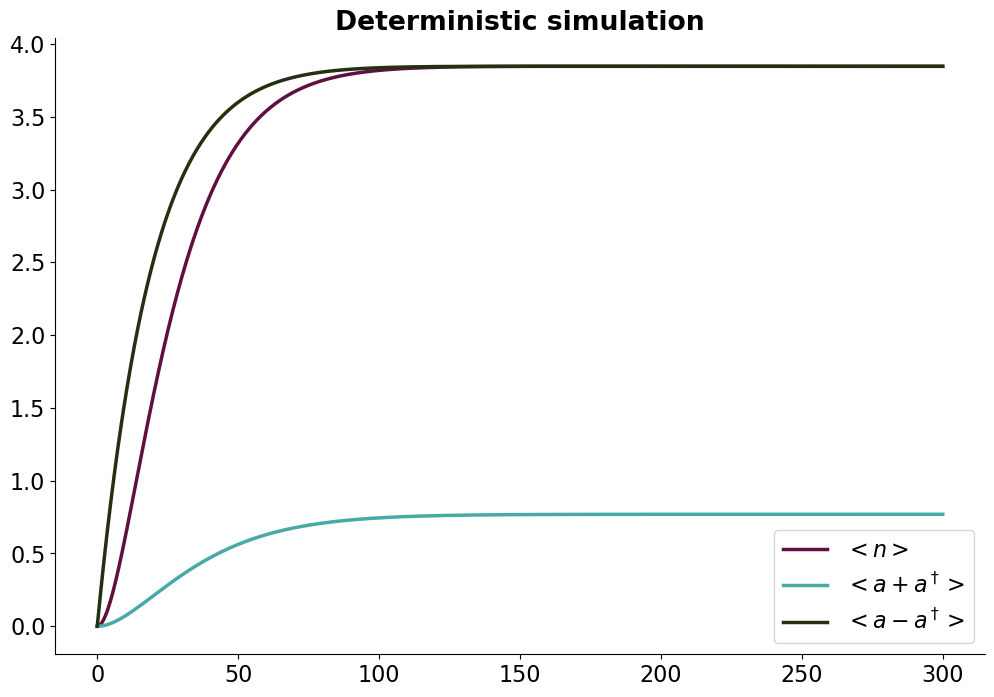

In [8]:
plt.plot(result_deterministic.times, result_deterministic.expect[0], label = "$<n>$")
plt.plot(result_deterministic.times, result_deterministic.expect[1], label = "$<a + a^\dagger>$")
plt.plot(result_deterministic.times, result_deterministic.expect[2], label = "$<a - a^\dagger>$")

plt.legend()
plt.title("Deterministic simulation")

In [40]:
efficiency = 1

from qutip import spre, spost, liouvillian, ket2dm, to_super, lindblad_dissipator
from qutip.expect import expect_rho_vec

# Here we define the deterministic part
L = liouvillian(H)
D = lindblad_dissipator(np.sqrt(photon_rate) * a)

# Collect in function
def evolution(time, rho_vec):
    return (L + D) * rho_vec

# Here we define the stochastic part
c1 = np.sqrt(efficiency * photon_rate / 2) * a
c2 = np.sqrt(efficiency * photon_rate / 2) * 1j * a 

super_c1 = spre(c1) + spost(c1.dag())
super_c2 = spre(c2) + spost(c2.dag())

# Collect in function
def measurement(time, rho_vec):
    expect1 = expect_rho_vec(super_c1.data, rho_vec, False)
    expect2 = expect_rho_vec(super_c2.data, rho_vec, False)
    drho1   = super_c1 * rho_vec - expect1 * rho_vec
    drho2   = super_c2 * rho_vec - expect2 * rho_vec
    return np.vstack([drho1, drho2])


# Run simulation
from qutip import general_stochastic, parallel_map, operator_to_vector

exp_vals = [spre(a_dag * a), spre(a + a_dag), spre((1j) * (a - a_dag))]

result_stochastic = general_stochastic(
    operator_to_vector(ket2dm(initial_state)),
    np.linspace(*driving_time, simulation_steps),
    evolution,
    measurement,
    e_ops = exp_vals,
    ntraj = 12,
    nsubsteps = 5,
    len_d2 = 2,
    progress_bar = True,
    map_func = parallel_map,
    solver = "platen",
    # store_all_expect = True,
    dW_factors = [np.sqrt(2 / photon_rate), np.sqrt(2 / photon_rate)],
    m_ops = [spre(a + a.dag()), 1j * spre(a - a.dag())],
    store_measurement = True
)

16.7%. Run time:  78.43s. Est. time left: 00:00:06:32
25.0%. Run time:  80.41s. Est. time left: 00:00:04:01
33.3%. Run time:  81.12s. Est. time left: 00:00:02:42
41.7%. Run time:  82.65s. Est. time left: 00:00:01:55
50.0%. Run time:  83.33s. Est. time left: 00:00:01:23
66.7%. Run time:  83.73s. Est. time left: 00:00:00:41
75.0%. Run time:  83.88s. Est. time left: 00:00:00:27
83.3%. Run time:  84.01s. Est. time left: 00:00:00:16
91.7%. Run time:  84.16s. Est. time left: 00:00:00:07
100.0%. Run time:  84.58s. Est. time left: 00:00:00:00
Total run time:  84.60s


(0.0, 8.0)

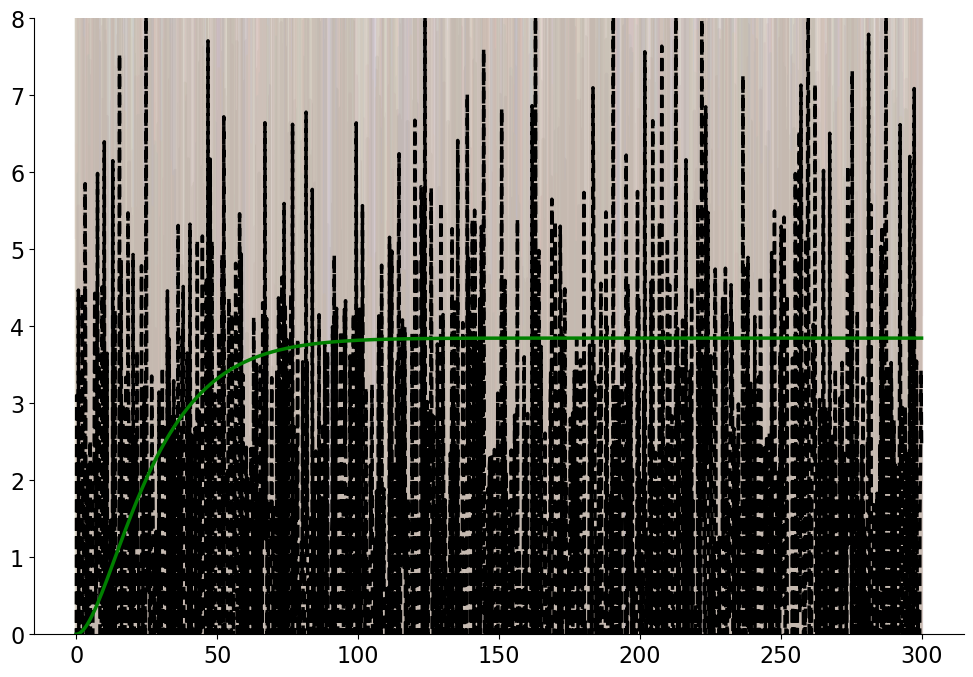

In [41]:
measurements = np.squeeze(np.array(result_stochastic.measurement))
times        = result_stochastic.times

for i in range(result_stochastic.ntraj):
    plt.plot(times, measurements[i, :, 0], alpha = 0.05)

plt.plot(times, measurements.mean(axis = 0)[:, 0], "k--")

# plt.plot(times, np.cumsum(measurements.mean(axis = 0)) / times, "k--")
plt.plot(times, result_stochastic.expect[0], label = "$<n>$", color = "green")

plt.ylim(0, 8)

/tmp/ipykernel_1586/2426793884.py:8: RuntimeWarning: divide by zero encountered in true_divide
  ax[0].plot(times, np.cumsum(measurements[i, :, 0]) * binwidth/ times, alpha = 0.15, color = "C0")
/tmp/ipykernel_1586/2426793884.py:8: RuntimeWarning: invalid value encountered in true_divide
  ax[0].plot(times, np.cumsum(measurements[i, :, 0]) * binwidth/ times, alpha = 0.15, color = "C0")
/tmp/ipykernel_1586/2426793884.py:9: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(times, np.cumsum(measurements[i, :, 1]) * binwidth/ times, alpha = 0.15, color = "C1")
/tmp/ipykernel_1586/2426793884.py:9: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(times, np.cumsum(measurements[i, :, 1]) * binwidth/ times, alpha = 0.15, color = "C1")


(0.0, 6.0)

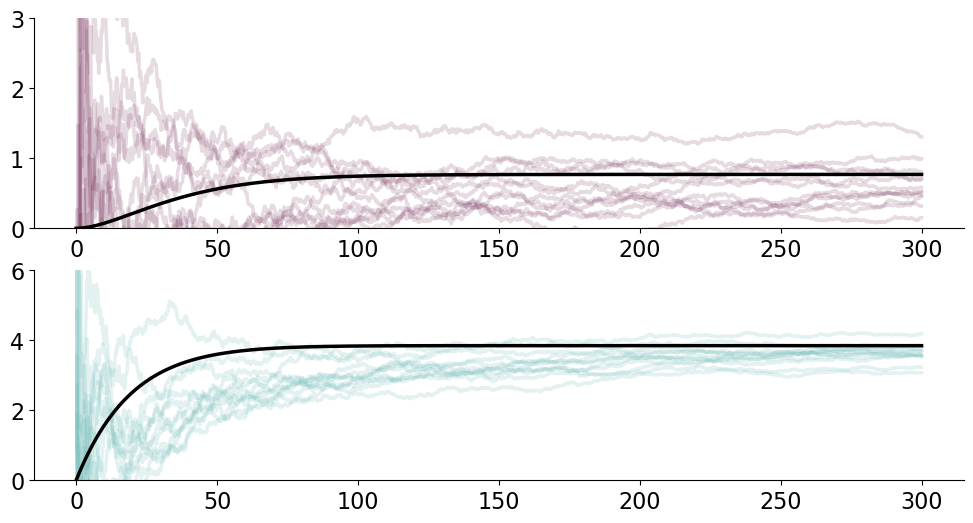

In [61]:
fig, ax = plt.subplots(2, 1, figsize = (12, 6))

measurements = np.squeeze(np.array(result_stochastic.measurement))
times        = result_stochastic.times
binwidth     = times[1] - times[0]

for i in range(result_stochastic.ntraj):
    ax[0].plot(times, np.cumsum(measurements[i, :, 0]) * binwidth/ times, alpha = 0.15, color = "C0")
    ax[1].plot(times, np.cumsum(measurements[i, :, 1]) * binwidth/ times, alpha = 0.15, color = "C1")

# plt.plot(times, measurements.mean(axis = 0), "k--")

# plt.plot(times, np.cumsum(measurements.mean(axis = 0)) / times, "k--")
ax[0].plot(times, result_stochastic.expect[1], label = "$<a + a^\dagger>$", color = "k")
ax[1].plot(times, result_stochastic.expect[2], label = "$i<a - a^\dagger>$", color = "k")


ax[0].set_ylim(0, 3)
ax[1].set_ylim(0, 6)

In [38]:
measurements.mean(axis=0)[50:, 1].shape

(1451,)

/tmp/ipykernel_1586/2093533750.py:3: RuntimeWarning: divide by zero encountered in true_divide
  avg_traj = lambda x: np.cumsum(x) * binwidth / times
/tmp/ipykernel_1586/2093533750.py:3: RuntimeWarning: invalid value encountered in true_divide
  avg_traj = lambda x: np.cumsum(x) * binwidth / times


(-5.0, 5.0)

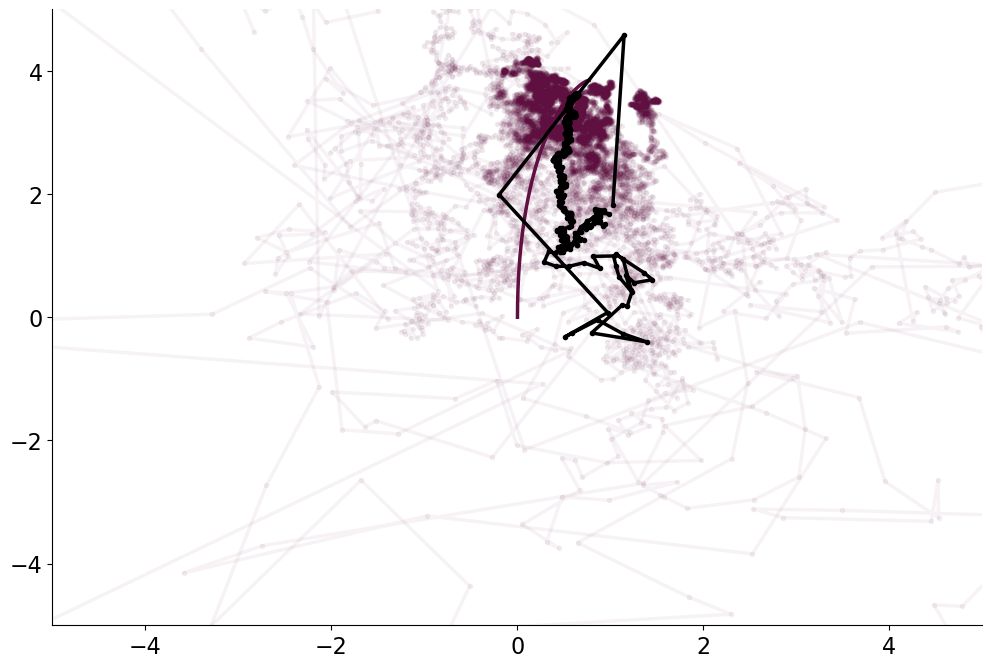

In [62]:
plt.plot(result_stochastic.expect[1], result_stochastic.expect[2], label = "Stochastic")

avg_traj = lambda x: np.cumsum(x) * binwidth / times

for i in range(result_stochastic.ntraj):
    plt.plot(avg_traj(measurements[i, :, 0])[:], avg_traj(measurements[i, :, 1])[:], alpha = 0.05, marker = ".", ls = "-", color = "C0")

plt.plot(avg_traj(measurements.mean(axis=0)[:, 0])[:], avg_traj(measurements.mean(axis=0)[:, 1])[:], "k", marker = ".")

plt.ylim(-5, 5)
plt.xlim(-5, 5)

/tmp/ipykernel_1586/3495356807.py:5: RuntimeWarning: divide by zero encountered in true_divide
  record = measurements.cumsum(axis = 1).real * binwidth / np.expand_dims(times, [0, -1])
/tmp/ipykernel_1586/2093533750.py:3: RuntimeWarning: invalid value encountered in true_divide
  avg_traj = lambda x: np.cumsum(x) * binwidth / times


(0.0, 4.0)

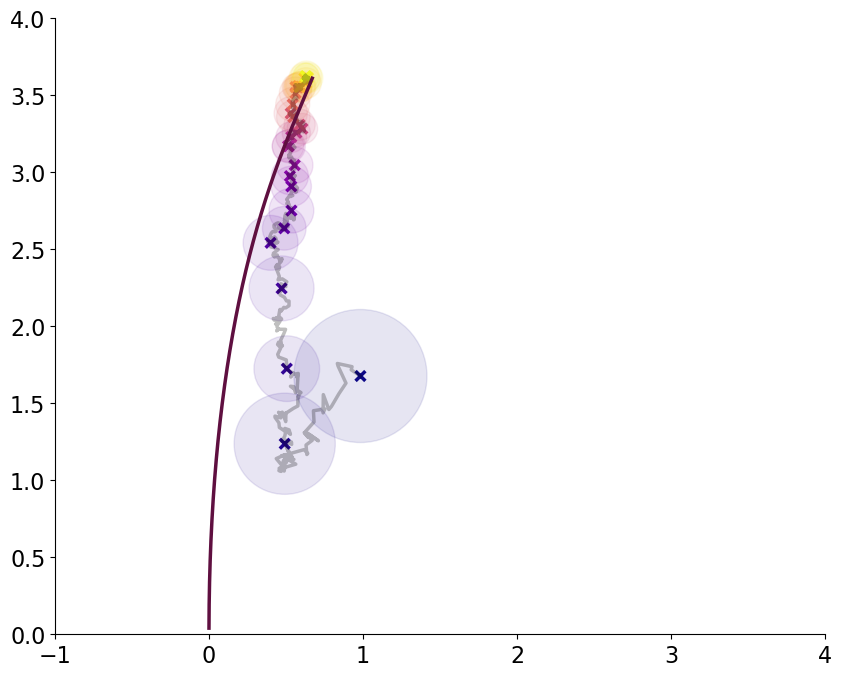

In [116]:
from ipywidgets import interact, FloatSlider
from matplotlib.patches import Circle


record = measurements.cumsum(axis = 1).real * binwidth / np.expand_dims(times, [0, -1])
points = record.mean(axis = 0).real

plot_points = points[50::50, :]
plot_stds   = record.std(axis = 0)[50::50, :] / np.sqrt(result_stochastic.ntraj) #  * np.expand_dims(times, axis = -1)[50::50])# * np.arange(50, 50 * len(plot_points) + 1, 50)), axis = -1)

cmap = plt.get_cmap("plasma")
cs   = cmap(np.linspace(0, 1, len(plot_points)))



for i, (x, y) in enumerate(plot_points):
    ax = plt.gca()
    ax.add_patch(Circle((x, y), plot_stds[i, 0], color = cs[i], alpha = 0.10))

plt.plot(*points[50:].T, color = "k", alpha = 0.25)
plt.scatter(*plot_points.T, color = cs, marker = "x", ls = "None", s = 50)

plt.plot(avg_traj(result_stochastic.expect[1]), avg_traj(result_stochastic.expect[2]), label = "Stochastic")


ax.set_aspect("equal")
ax.set_xlim(-1, 4)
ax.set_ylim(0, 4)

In [ ]:
from ipywidgets import interact, FloatSlider
from matplotlib.patches import Circle


record = measurements.cumsum(axis = 1).real * binwidth / np.expand_dims(times, [0, -1])
points = record.mean(axis = 0).real

plot_points = points[50::50, :]
plot_stds   = record.std(axis = 0)[50::50, :] / np.sqrt(result_stochastic.ntraj * np.expand_dims(times, axis = -1)[50::50])# * np.arange(50, 50 * len(plot_points) + 1, 50)), axis = -1)

cmap = plt.get_cmap("plasma")
cs   = cmap(np.linspace(0, 1, len(plot_points)))



for i, (x, y) in enumerate(plot_points):
    ax = plt.gca()
    ax.add_patch(Circle((x, y), plot_stds[i, 0], color = cs[i], alpha = 0.10))

plt.plot(*points[50:].T, color = "k", alpha = 0.25)
plt.scatter(*plot_points.T, color = cs, marker = "x", ls = "None", s = 50)

plt.plot(avg_traj(result_stochastic.expect[1]), avg_traj(result_stochastic.expect[2]), label = "Stochastic")


ax.set_aspect("equal")
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

In [97]:
x, y

((0.6283421074825823+1.6199611575992996e-15j),
 (3.623811458842334+1.9344570425874882e-15j))

Text(0.5, 1.0, 'Stochastic simulation')

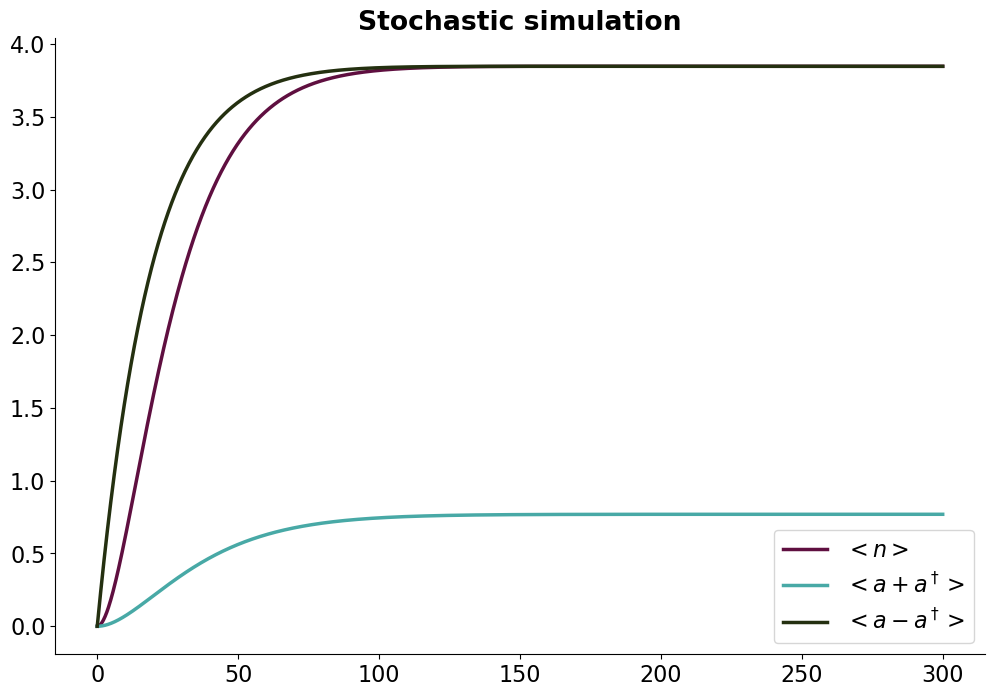

In [52]:
plt.plot(result_stochastic.times, result_stochastic.expect[0], label = "$<n>$")
plt.plot(result_stochastic.times, result_stochastic.expect[1], label = "$<a + a^\dagger>$")
plt.plot(result_stochastic.times, result_stochastic.expect[2], label = "$<a - a^\dagger>$")

plt.legend()
plt.title("Stochastic simulation")